In [1]:
import os

# to turn off SupervisionWarnings, note that the following code must be run before importing anything from supervision
# https://github.com/roboflow/supervision/pull/962/commits/7d65a9445aa04d82334c6fe2828278e528eda1cb
os.environ["SUPERVISON_DEPRECATION_WARNING"] = "0"

In [2]:
from pathlib import Path
import json
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import shutil
from utils import load_image, annotate

In [3]:
# Define the base directory
dataset_dir = Path("..")

# Define the images directory and duplicates directory using Path objects
image_dir = dataset_dir / "images"
dup_dir = dataset_dir / "duplicates"
meta_dir = dataset_dir / "metadata"
ann_dir = dataset_dir / "annotations"

# List all objects in the image directory
objs = sorted([obj.name for obj in image_dir.iterdir()])

In [4]:
with open(meta_dir / "id_to_name.json", "r") as f:
    id_to_name = json.load(f)

## check images with no annotations in [0] but have annotations in [1]

naming convention:

e.g. 35n_25y means comparing images that doesn't have annotations if box_threshold is set as 0.35 but have annotations if box_threshold is 0.25

In [23]:
comp_groups = [[35, 25], [35, 30], [40, 35], [45, 40]]

In [24]:
for comp_g in comp_groups:
    label_dir_no = dataset_dir / f"labels_0.{comp_g[0]}_0.25"
    label_dir_yes = dataset_dir / f"labels_0.{comp_g[1]}_0.25"

    with open(label_dir_yes / "labels.json", "r") as f:
        labels_nms_yes = json.load(f)["nms"]

    with open(label_dir_no / "no_ann.json", "r") as f:
        no_ann_no = json.load(f)
    with open(label_dir_yes / "no_ann.json", "r") as f:
        no_ann_yes = json.load(f)

    result_folder = Path(f"../annotations_{comp_g[0]}n_{comp_g[1]}y")
    result_folder.mkdir(exist_ok=True)

    no_ann_diff = list(set(no_ann_no) - set(no_ann_yes))

    print(
        f"Number of images with no annotations in {comp_g[0]} but with annotations in {comp_g[1]}: {len(no_ann_diff)}"
    )

    # if save images
    for _, id in enumerate(no_ann_diff):
        file = id + ".jpg"
        obj = id_to_name[file].split("/")[0]
        img_path = image_dir / obj / file
        if not img_path.exists():
            print(f"{img_path} does not exist")
            continue
        img = load_image(img_path, size=800)
        boxes_xywh = labels_nms_yes[id]["boxes"]
        if len(boxes_xywh) == 0:
            img.save(result_folder / file)
        else:
            logits = labels_nms_yes[id]["logits"]
            phrases = labels_nms_yes[id]["phrases"]
            annotated_frame = annotate(img, boxes_xywh, logits, phrases)
            annotated_frame.save(result_folder / file)

Number of images with no annotations in 35 but with annotations in 25: 243
Number of images with no annotations in 35 but with annotations in 30: 210
Number of images with no annotations in 40 but with annotations in 35: 706
Number of images with no annotations in 45 but with annotations in 40: 1148


## more stats for 35n_25y

In [35]:
# more stats for 35n_25y
comp_g = [35, 25]
label_dir_no = dataset_dir / f"labels_0.{comp_g[0]}_0.25"
label_dir_yes = dataset_dir / f"labels_0.{comp_g[1]}_0.25"

with open(label_dir_yes / "labels.json", "r") as f:
    labels_nms_yes = json.load(f)["nms"]

with open(label_dir_no / "no_ann.json", "r") as f:
    no_ann_no = json.load(f)
with open(label_dir_yes / "no_ann.json", "r") as f:
    no_ann_yes = json.load(f)

result_folder = Path(f"../annotations_{comp_g[0]}n_{comp_g[1]}y")
result_folder.mkdir(exist_ok=True)
no_ann_diff = list(set(no_ann_no) - set(no_ann_yes))

labels_relevant = [labels_nms_yes[k] for k in no_ann_diff]
scores_relevant = [label["logits"] for label in labels_relevant]
scores_relevant = [score for scores in scores_relevant for score in scores]

(array([ 3., 10., 13., 15., 22., 16., 38., 45., 55.]),
 array([0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34]),
 <BarContainer object of 9 artists>)

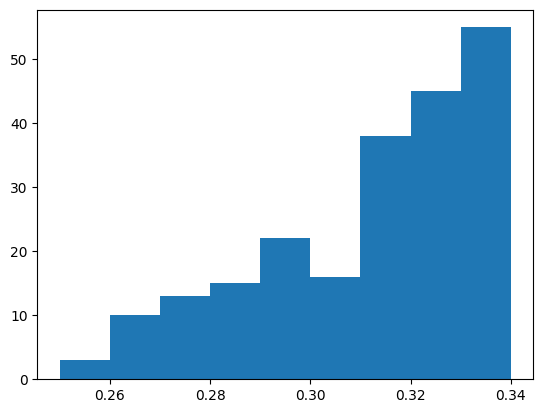

In [32]:
plt.hist(scores_relevant, bins=np.arange(0.25, 0.35, 0.01))

In [46]:
# get the indexes of the annotations with logits between 0.25 and 0.27
idxs = []
for i, label in enumerate(labels_relevant):
    for score in label["logits"]:
        if 0.27 <= score <= 0.28:
            idxs.append(i)
ids = sorted([no_ann_diff[i] for i in idxs])

In [47]:
for id in ids:
    print(id)
    print(labels_nms_yes[id]["logits"])

00494
[0.2792578339576721]
00601
[0.3212573528289795, 0.27930694818496704]
00602
[0.3018553853034973, 0.2787165939807892]
00638
[0.3248947262763977, 0.27209657430648804]
02051
[0.2739858329296112]
05959
[0.3287976384162903, 0.2739144563674927]
06192
[0.2754422426223755]
06721
[0.2975076735019684, 0.27620983123779297]
07011
[0.28566569089889526, 0.27596667408943176]
07653
[0.34092071652412415, 0.2737738788127899]
07892
[0.27228277921676636]
08314
[0.3408918082714081, 0.27030354738235474]
08919
[0.2760041058063507]


In [48]:
# move the images to a new folder
tmp_folder = Path("../tmp")
tmp_folder.mkdir(exist_ok=True)
for id in ids:
    file = id + ".jpg"
    src = result_folder / file
    if not src.exists():
        print(f"{src} does not exist")
        continue
    dst = tmp_folder / file
    shutil.move(src, dst)

..\annotations_35n_25y\00494.jpg does not exist
..\annotations_35n_25y\00601.jpg does not exist
..\annotations_35n_25y\00602.jpg does not exist
..\annotations_35n_25y\00638.jpg does not exist
..\annotations_35n_25y\02051.jpg does not exist
..\annotations_35n_25y\05959.jpg does not exist
..\annotations_35n_25y\06192.jpg does not exist
..\annotations_35n_25y\06721.jpg does not exist
..\annotations_35n_25y\07011.jpg does not exist
..\annotations_35n_25y\07653.jpg does not exist
..\annotations_35n_25y\07892.jpg does not exist
..\annotations_35n_25y\08314.jpg does not exist
..\annotations_35n_25y\08919.jpg does not exist


## decide which images to prompt to gpt4

after previous 2 blocks, box_threshold is set to 0.27, 

now check out stats and images with different logits threshold

In [5]:
label_dir = dataset_dir / "labels"
with open(label_dir / "labels.json", "r") as f:
    labels_nms = json.load(f)["nms"]

### plot iamges based on labels

In [6]:
image_annotated_dir = dataset_dir / "images_annotated"

for id in labels_nms:
    file = id + ".jpg"
    obj = id_to_name[file].split("/")[0]
    img_path = image_dir / obj / file
    annotated_img_path = image_annotated_dir / obj / file
    if annotated_img_path.exists():
        continue
    if not img_path.exists():
        print(f"{img_path} does not exist")
        continue
    boxes_xywh = labels_nms[id]["boxes"]
    if len(boxes_xywh) == 0:
        continue

    logits = labels_nms[id]["logits"]
    classes = labels_nms[id]["classes"]
    img = load_image(img_path, size=512)
    annotated_frame = annotate(img, boxes_xywh, logits, classes)
    annotated_img_path.parent.mkdir(exist_ok=True, parents=True)
    annotated_frame.save(annotated_img_path)

In [7]:
socres_all = [ann["logits"] for ann in labels_nms.values()]
socres_all = [score for scores in socres_all for score in scores]
len(socres_all)

17309

(array([  25.,  904., 2348., 4032., 3467., 3111., 2499.,  923.]),
 array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 8 artists>)

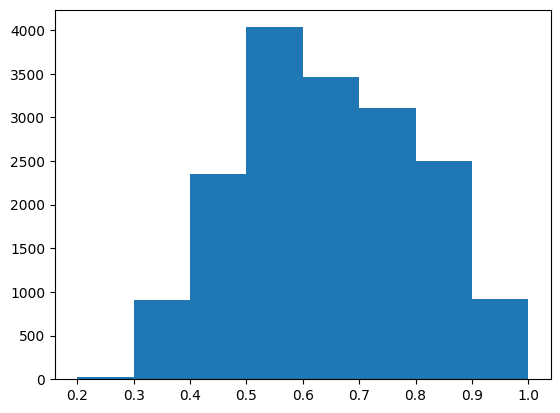

In [8]:
plt.hist(socres_all, bins=np.arange(0.2, 1.1, 0.1))

In [9]:
# split images based on bins
image_by_score = dataset_dir / "images_by_score"
# labeled_image_dir = ann_dir/ 'nms'/ 'images'
src_to_dst = {}

bins = np.arange(1.0, 0.1, -0.1)
for i in range(len(bins) - 1):
    bin_min = bins[i + 1]
    bin_max = bins[i]
    ids = [
        id
        for id, ann in labels_nms.items()
        if any([bin_min <= score <= bin_max for score in ann["logits"]])
    ]
    print(
        f"Number of images with logits between {bin_min:.1f} and {bin_max:.1f}: {len(ids)}"
    )
    for id in ids:
        file = id + ".jpg"
        obj = id_to_name[file].split("/")[0]
        src = image_annotated_dir / obj / file
        dst = image_by_score / f"{bin_min:.1f}-{bin_max:.1f}" / obj / file
        # dst = image_by_score / f'{bin_min:.1f}-{bin_max:.1f}' / file

        src_to_dst[src] = (
            dst  # key updated by smallest bin if the same image is in multiple bins
        )
        dst.parent.mkdir(parents=True, exist_ok=True)


for src, dst in src_to_dst.items():
    if not src.exists():
        print(f"{src} does not exist")
        continue
    else:
        shutil.copy(src, dst)

Number of images with logits between 0.9 and 1.0: 923
Number of images with logits between 0.8 and 0.9: 2499
Number of images with logits between 0.7 and 0.8: 3011
Number of images with logits between 0.6 and 0.7: 3129
Number of images with logits between 0.5 and 0.6: 3394
Number of images with logits between 0.4 and 0.5: 2348
Number of images with logits between 0.3 and 0.4: 904
Number of images with logits between 0.2 and 0.3: 25


In [10]:
to_gpt = []
for id, ann in labels_nms.items():
    if len(ann["logits"]) > 1:
        to_gpt.append(id)

    elif any([score < 0.5 for score in ann["logits"]]):
        to_gpt.append(id)

len(to_gpt)

4776

In [11]:
with open(meta_dir / "to_gpt.json", "w") as f:
    json.dump(to_gpt, f)